In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [33]:
path = 'logs/superpoint_socket_sto_train2/predictions'
files = list(range(100))

data = dict()
data_to_load = ['desc', 'image', 'prob', 'warped_desc', 'warped_image', 'warped_prob',]

for file in files:
    file_path = path + '/' + str(file) + '.npz'
    with np.load(file_path) as f:
        #print(f['desc'])
        data[file] = {name:f[name] for name in data_to_load}

In [34]:
data[5]['prob'].shape, data[5]['desc'].shape, data[5]['warped_prob'].shape, data[5]['warped_desc'].shape

((241, 3), (241, 256), (336, 3), (336, 256))

In [35]:
def l2_sim(desc1, all_desc2):
    res = np.sum((all_desc2 - desc1)**2, axis=1)
    return res

def closest_desc(desc1, all_desc2, n_best=5):
    sim = l2_sim(desc1, all_desc2)
    df_sim = pd.DataFrame(sim, columns=['sim'])
    df_sim['coord'] = range(len(df_sim))
    df_sim['rank'] = df_sim['sim'].rank()
    df_sim = df_sim.sort_values('rank')

    return df_sim.head(n_best)['coord'].values 

def closest_points(point1, all_points2, desc1, all_desc2, rad=3, n_best=5):
    n_best_point_index = closest_desc(desc1, all_desc2, n_best)
    n_best_point = all_points2[n_best_point_index, :2]

    distance = np.sqrt(l2_sim(point1[:2], n_best_point))
    
    if len(distance) == np.sum(distance > rad):
        return -1
    else:
        return np.argmin(distance)
    
def vec_closest_points(all_points1, all_points2, all_desc1, all_desc2, rad=3, n_best=5):
    n = len(all_points1)
    res = np.zeros(n)
    for i in range(n):
        res[i] = closest_points(all_points1[i], all_points2, all_desc1[i], all_desc2, rad, n_best)
    return res

In [36]:
all_pairs = data.keys()

df_res = pd.DataFrame()

for img in tqdm(all_pairs):

    points = data[img]['prob']
    warped_points = data[img]['warped_prob']

    desc = data[img]['desc']
    warped_desc = data[img]['warped_desc']


    vec = vec_closest_points(points, warped_points, desc, warped_desc, rad=3, n_best=5)
    df_res[img] = vec
    

In [37]:
df_bres = (df_res != -1).astype(int)
df_bres['sum'] = df_bres.sum(axis=1)
df_bres['share'] = df_bres['sum'] / (df_bres.shape[1]-1) 
df_bres = df_bres.sort_values('share', ascending=False)
df_bres.head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,sum,share
66,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,98,0.98
69,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,98,0.98
100,1,1,1,1,1,0,0,1,1,1,...,1,1,1,1,1,1,1,1,97,0.97
109,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,97,0.97
128,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,97,0.97
124,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,97,0.97
151,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,97,0.97
101,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,96,0.96
73,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,96,0.96
71,1,1,1,1,1,0,0,0,1,1,...,1,1,1,1,1,1,1,1,96,0.96


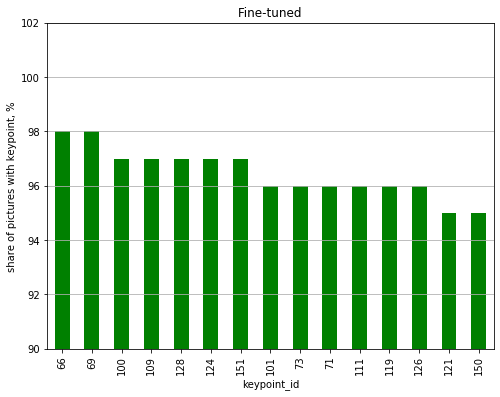

In [39]:
df_to_plot = df_bres.head(15)['share']

plt.figure(figsize=(8, 6))

(df_to_plot*100).plot(kind='bar', color='g')
plt.title('Fine-tuned')
plt.ylim(90,102)
plt.grid(axis='y')
plt.ylabel('share of pictures with keypoint, %')
plt.xlabel('keypoint_id')
plt.show()

In [139]:
df_to_plot

41     1.00
145    0.99
160    0.99
72     0.99
117    0.99
124    0.99
125    0.99
43     0.99
37     0.99
92     0.99
6      0.99
93     0.98
108    0.98
2      0.97
60     0.97
9      0.97
8      0.97
71     0.97
49     0.97
111    0.97
Name: share, dtype: float64

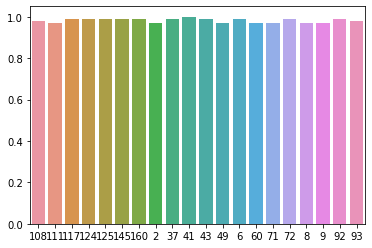

In [128]:

sns.barplot(df_to_plot.index.astype(str), df_to_plot.values)

In [103]:
np.unique(df_bres['sum'], return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  27,  28,  29,
         30,  31,  32,  33,  35,  36,  37,  38,  39,  40,  42,  45,  46,
         47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  77,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([ 2,  3,  3,  6,  3,  4,  2,  2,  3,  1,  1,  2,  1,  2,  1,  1,  1,
         2,  2,  1,  1,  2,  1,  1,  4,  1,  3,  4,  2,  2,  3,  5,  2,  3,
         1,  2,  4,  1,  1,  4,  5,  3,  2,  5,  2,  4,  1,  2,  2,  4,  2,
         2,  2,  3,  5,  1,  2,  4,  3,  2,  4,  3,  1,  5,  4,  1,  3,  3,
         3,  3,  1,  1,  2,  3,  5,  2,  4,  5, 13,  4,  5, 11, 11,  7,  4,
         6,  8,  2, 10,  1]))

In [117]:
df_pres = (df_res != -1).astype(int).T
df_pres['sum'] = df_pres.sum(axis=1)
df_pres['share'] = df_pres['sum'] / (df_pres.shape[1]-1) 
df_pres = df_pres.sort_values('sum')
df_pres

,0,1,2,3,4,5,6,7,8,9,...,273,274,275,276,277,278,279,280,sum,share
5,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,59,0.209964
18,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,74,0.263345
6,0,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,1,0,91,0.323843
8,0,0,1,0,0,0,1,0,1,1,...,0,1,0,1,0,0,0,1,91,0.323843
7,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,102,0.362989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,199,0.708185
45,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,202,0.718861
47,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,203,0.722420
4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,204,0.725979


In [110]:
import seaborn as sns

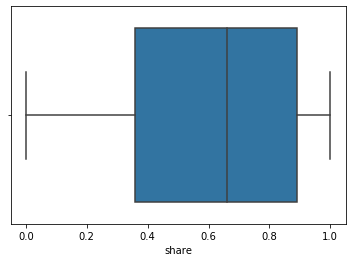

In [111]:
sns.boxplot(df_bres['share'])
plt.show()